# Load data

In [1]:
# import libraries
import numpy as np
import sys
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from scipy.stats import pearsonr

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
hfont = {'family':'sans-serif','fontname':'Helvetica', 'size':20}
mpl.rc('font',family='sans-serif', size=16)

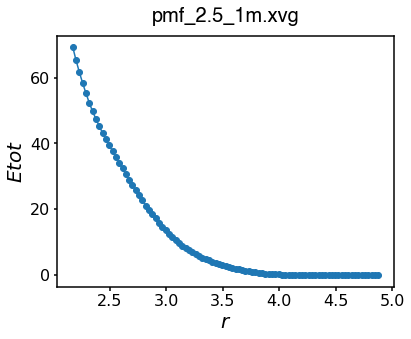

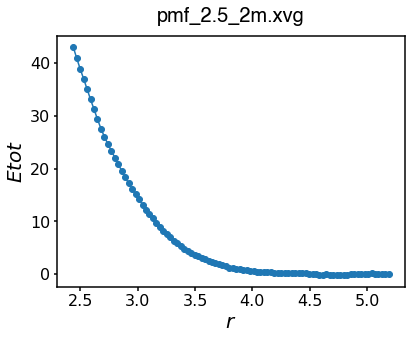

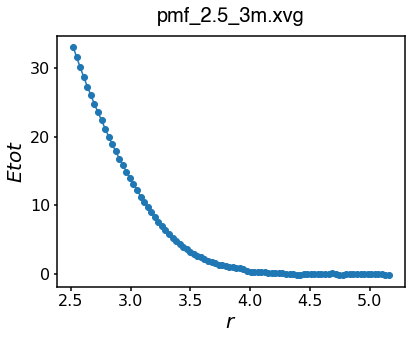

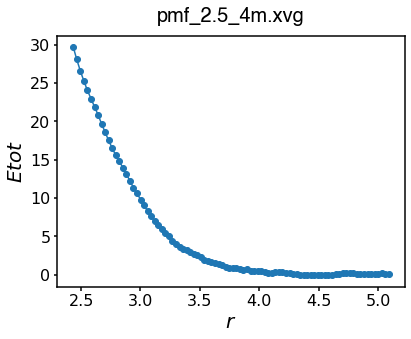

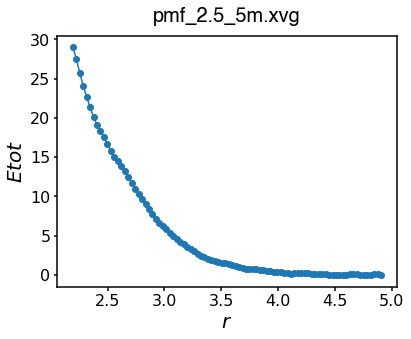

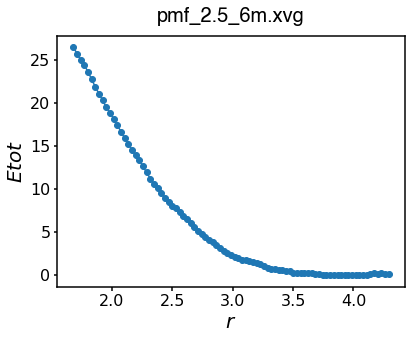

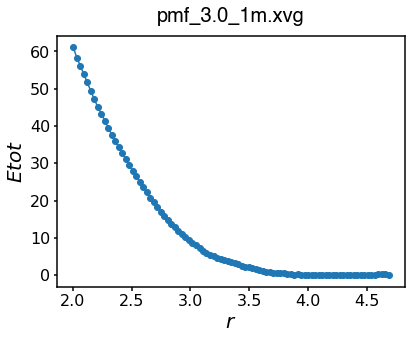

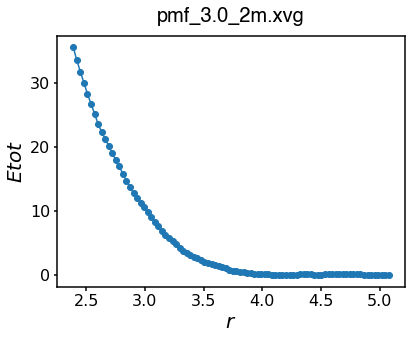

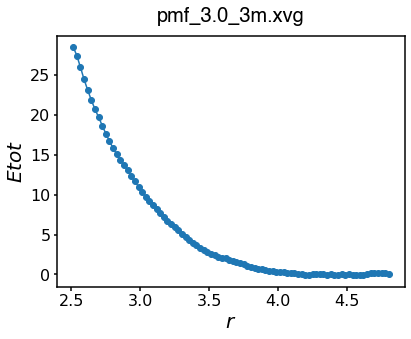

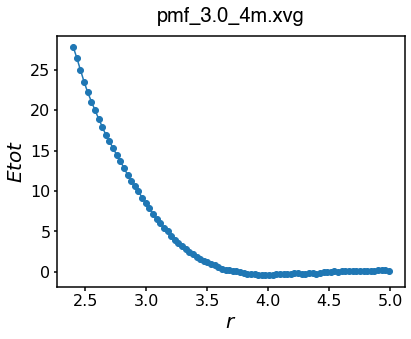

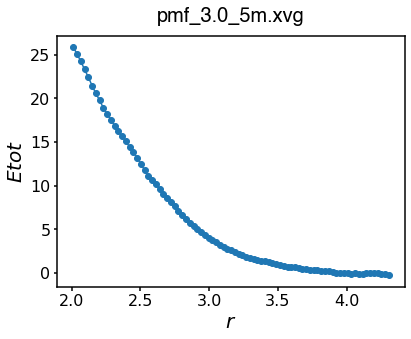

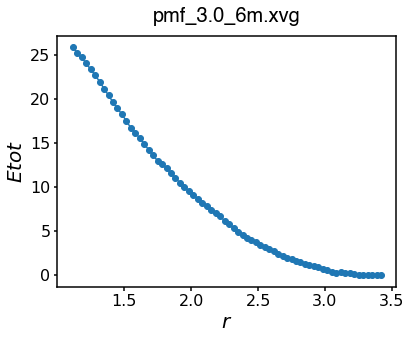

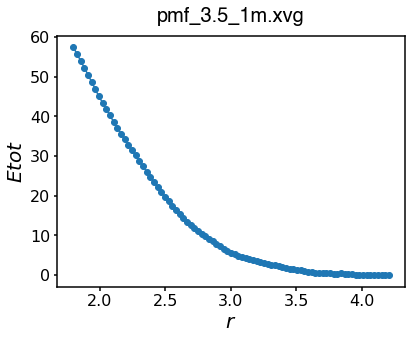

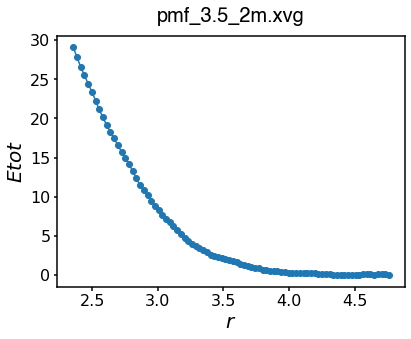

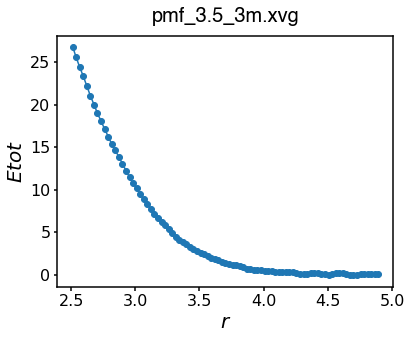

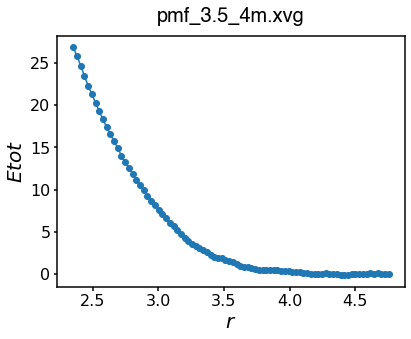

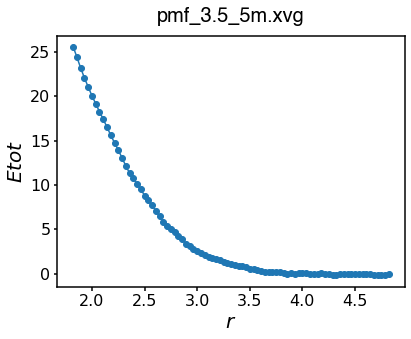

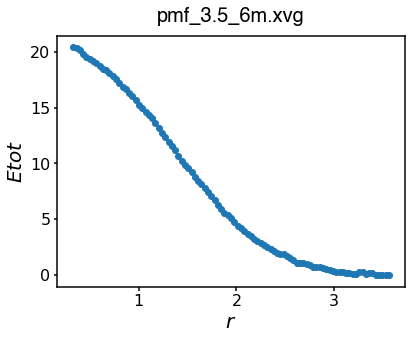

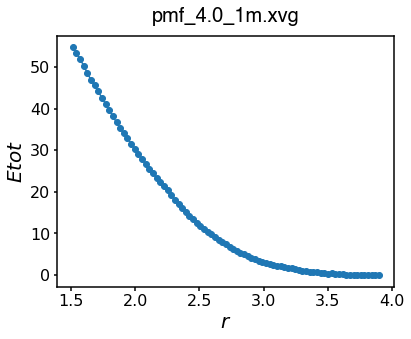

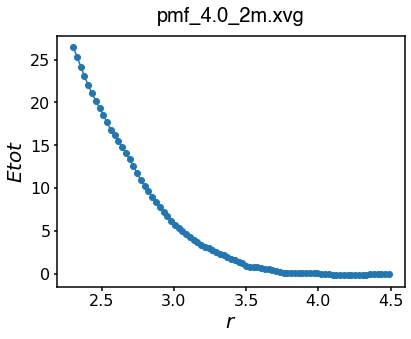

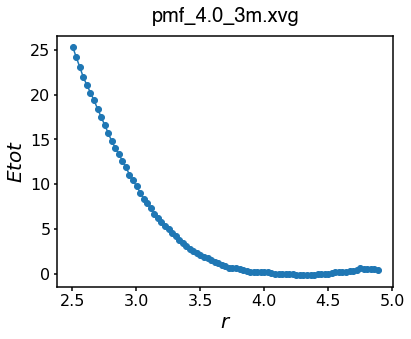

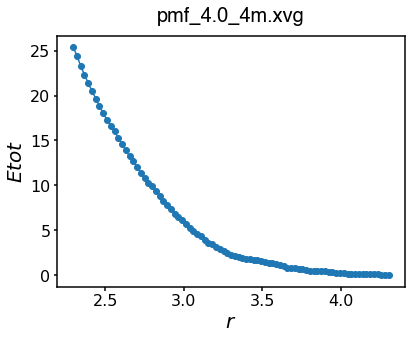

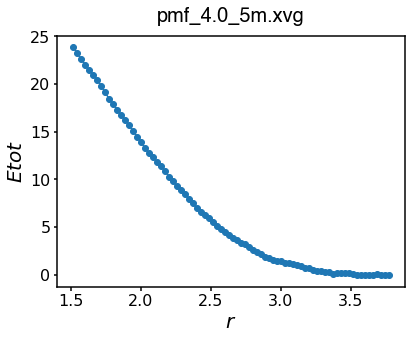

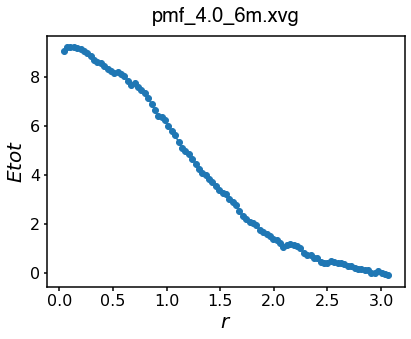

In [2]:
# load data
directory = 'Data3body'
file_names = os.listdir(directory)
file_names.sort()
Nwindows = len(file_names)
data = []
sizes = []
for file_name in file_names:
    file_name = os.path.join(directory, file_name)
    file_in = open(file_name, 'r')
    lines = file_in.readlines()
    file_in.close()
    temp = [line.split() for line in lines]
    # remove last 3 points
    temp = temp[:-3][:]
    selected = []
    # remove examples with a minimum distance < 2.5
    for el in temp:
        el = np.array(el, dtype=np.float64)
        parA = el[0:3]
        parB = el[3:6]
        parX = el[6:9]
        rXA = np.linalg.norm(parA-parX)
        rXB = np.linalg.norm(parB-parX)
        if(rXA>=2.5 and rXB>=2.5):
            selected.append(el)
    sizes.append(len(selected))
    data += selected
data = np.array(data, dtype=np.float64)
parA = data[:,0:3]
parB = data[:,3:6]
parX = data[:,6:9]
Etot = data[:,-1]

# plot data
cum = 0
for size, file_name in zip(sizes, file_names):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title(file_name, hfont, y=1.03)
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Etot[cum:cum+size], '-o')
    ax.set_xlabel(r'$r$', **hfont)
    ax.set_ylabel(r'$Etot$', **hfont)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    ax.tick_params(which='major', width=1.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    fig.tight_layout()
    plt.show()
    cum += size

# Load parameter of 2 body fit and define pairwise energy

In [3]:
def fc1(rij, rc):
    f = (rij<rc)*np.tanh(1-rij/rc)**3
    return f

def fc2(rij, rc):
    f = (rij<rc)*0.5*(np.cos(np.pi*rij/rc)+1.0)
    return f

def G2(rij, rc, rs, eta, fc=fc1):
    f = fc(rij, rc)*np.exp(-eta*(rij-rs)**2)
    return f

def pairwise_energy(rij, coef_list, rc_list, rs_list, eta_list):
    energy = 0.0
    for coef, rc, rs, eta in zip(coef_list, rc_list, rs_list, eta_list):
        energy += coef*G2(rij, rc, rs, eta)
    return energy

# load parameters of 2-body fit
path = './fit2np/params.npy'
params = np.load(path)
# print(params.shape)
coef2 = params[:,0]
rc2 = params[:,1]
rs2 = params[:,2]
eta2 = params[:,3]

# Substract 2-body contributions from 3-body free energies

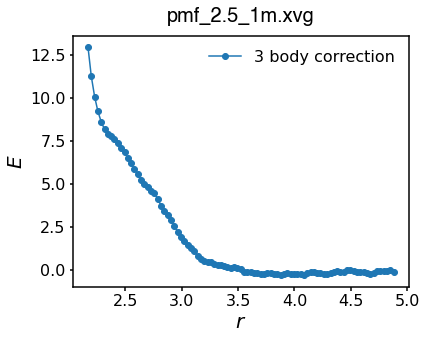

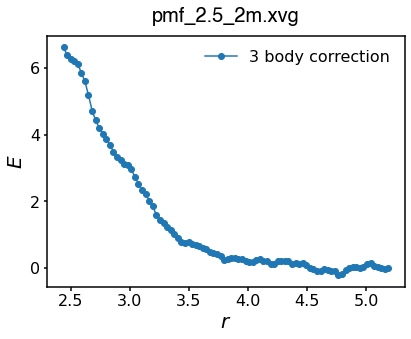

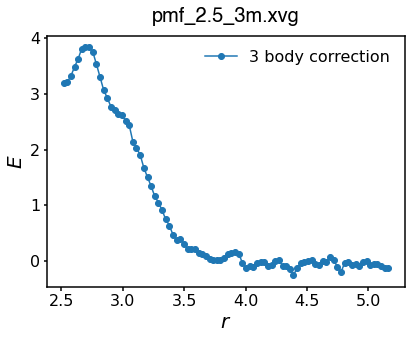

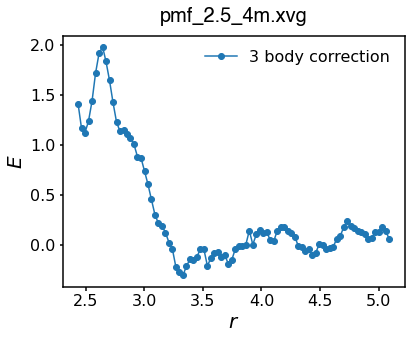

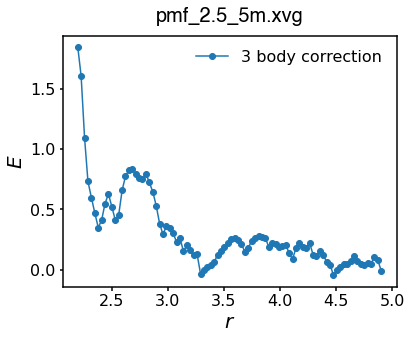

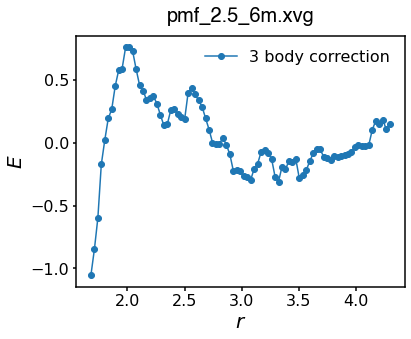

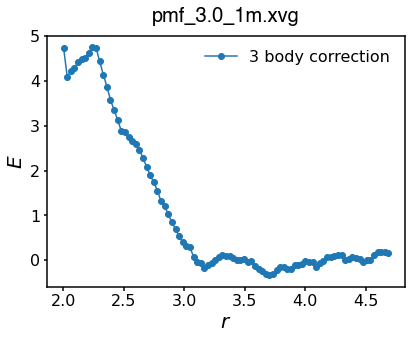

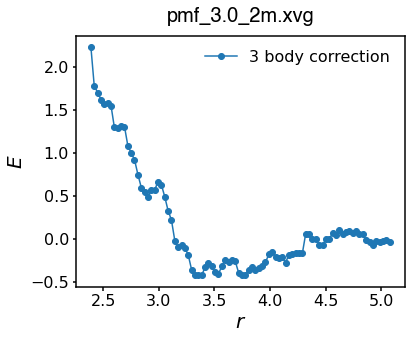

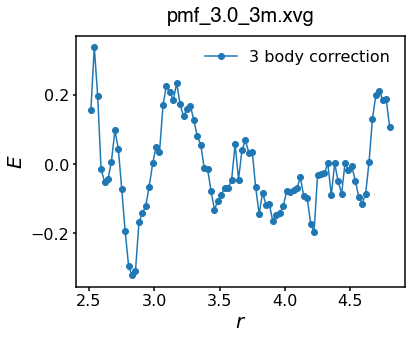

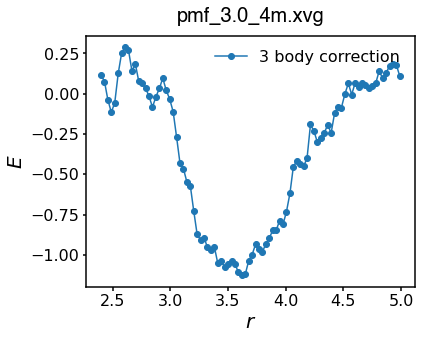

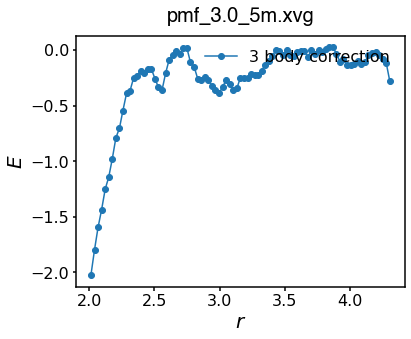

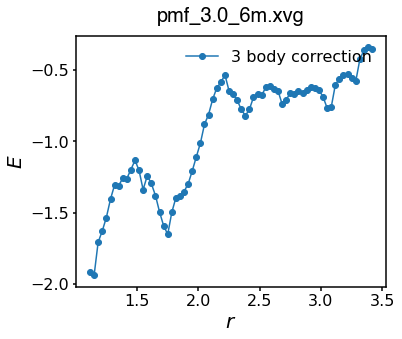

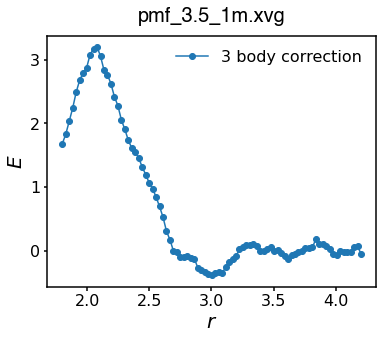

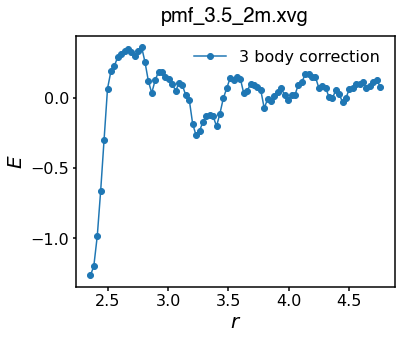

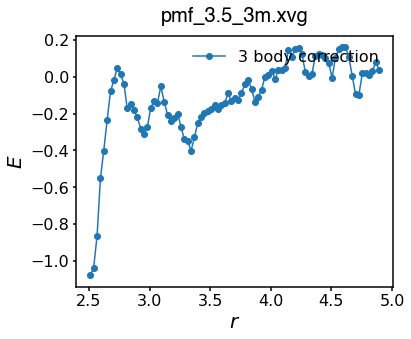

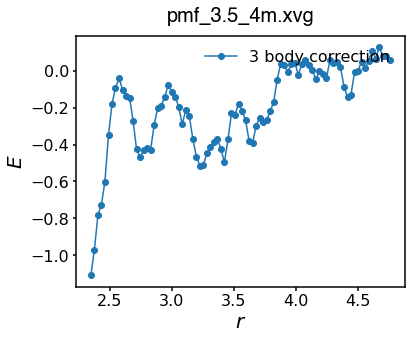

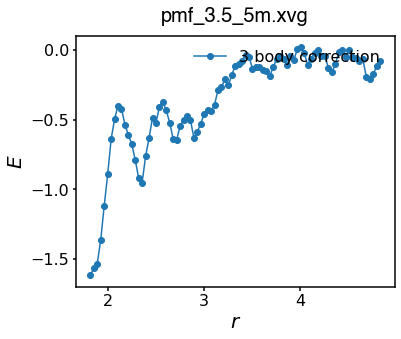

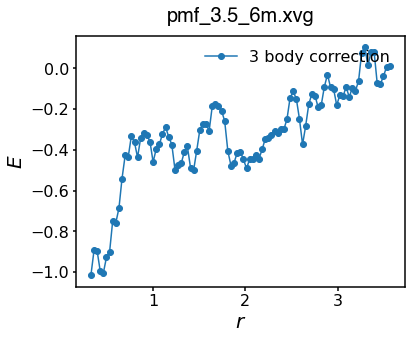

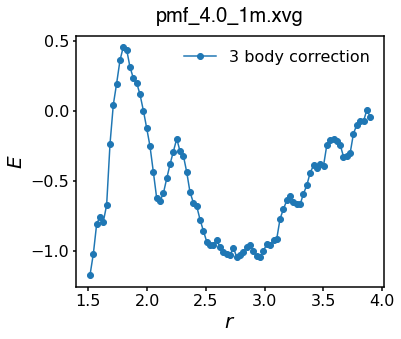

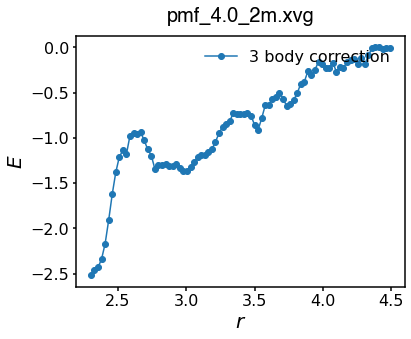

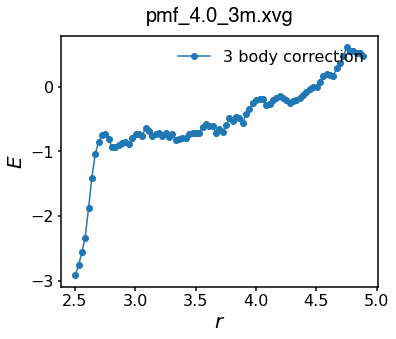

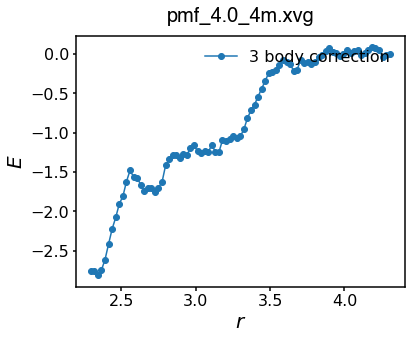

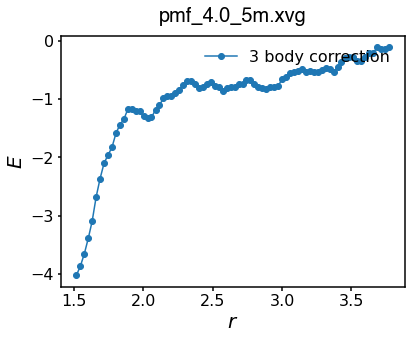

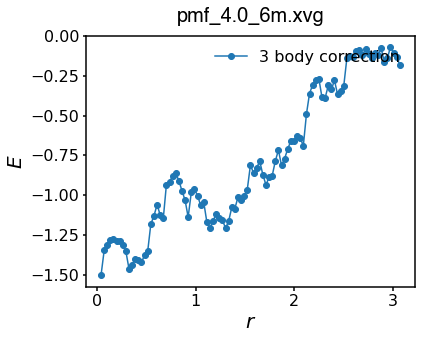

In [4]:
# Substract 2-body contributions from 3-body free energies
rXA = np.linalg.norm(parA-parX, axis=1)
rXB = np.linalg.norm(parB-parX, axis=1)
E = np.zeros(len(Etot))
EXA = np.zeros(len(Etot))
EXB = np.zeros(len(Etot))
for i in range(len(E)):
    EXA[i] = pairwise_energy(rXA[i], coef2, rc2, rs2, eta2)
    EXB[i] = pairwise_energy(rXB[i], coef2, rc2, rs2, eta2)
    E[i] = Etot[i] - EXA[i] - EXB[i]

# plot
cum = 0
for size, file_name in zip(sizes, file_names):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title(file_name, hfont, y=1.03)
#     ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Etot[cum:cum+size], '-o', label='full 3 body')
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], E[cum:cum+size], '-o', label='3 body correction')
    ax.set_xlabel(r'$r$', **hfont)
    ax.set_ylabel(r'$E$', **hfont)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    ax.tick_params(which='major', width=1.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.legend(prop=dict(size=16))
    ax.legend(loc="upper right", frameon=False)
    fig.tight_layout()
    plt.show()
    cum += size

# Build pool of candidates

In [5]:
def G3(rij, rik, rjk, cosine, rc, l, eta, epsilon, fc=fc1):
    f = 2.0**(1.0-epsilon)*fc(rij, rc)*fc(rik, rc)*fc(rjk, rc)*np.exp(-eta*(rij**2+rik**2+rjk**2))*(1.0+l*cosine)**epsilon
    return f

def G4(rij, rik, cosine, rc, l, eta, epsilon, fc=fc1):
    f = 2.0**(1.0-epsilon)*fc(rij, rc)*fc(rik, rc)*np.exp(-eta*(rij**2+rik**2))*(1.0+l*cosine)**epsilon
    return f

# build sets of parameters

# first G2 type
rc_set = np.array([4.5, 4.7])
rs_set = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
eta_set = np.array([0.0, 0.001, 0.01, 0.1, 1, 2, 4, 8])

rc_list1 = [rc for rc in rc_set for rs in rs_set for eta in eta_set]
rs_list1 = [rs for rc in rc_set for rs in rs_set for eta in eta_set]
eta_list1 = [eta for rc in rc_set for rs in rs_set for eta in eta_set]
Nlist1 = len(rc_list1)


# then G3 and G4 types
rc_set = np.array([4.5, 4.7])
l_set = np.array([1.0,-1.0])
eta_set = np.array([0.001, 0.01, 0.1, 1, 2])
eps_set = np.array([1,2,4,8])

rc_list2 = [rc for rc in rc_set for l in l_set for eta in eta_set for eps in eps_set]
l_list2 = [l for rc in rc_set for l in l_set for eta in eta_set for eps in eps_set]
eta_list2 = [eta for rc in rc_set for l in l_set for eta in eta_set for eps in eps_set]
eps_list2 = [eps for rc in rc_set for l in l_set for eta in eta_set for eps in eps_set]
Nlist2 = len(rc_list2)

# get complete list
rc_list = rc_list1 + rc_list2 + rc_list2
rs_list = rs_list1 + [0.0]*2*Nlist2
l_list = [0.0]*Nlist1 + l_list2 + l_list2
eta_list = eta_list1 + eta_list2 + eta_list2
eps_list = [0.0]*Nlist1 + eps_list2 + eps_list2
type_list = [2]*Nlist1 + [3]*Nlist2 + [4]*Nlist2
# print(len(l_list))

# compute distances and angles for building SFs
dXA = parA - parX
dXB = parB - parX
dAB = parB - parA
rXA = np.linalg.norm(dXA, axis=1)
rXB = np.linalg.norm(dXB, axis=1)
rAB = np.linalg.norm(dAB, axis=1)
cosineXAB = np.sum(dXA*dXB, axis=1)/(rXA*rXB)
cosineAXB = np.sum(-1*dXA*dAB, axis=1)/(rXA*rAB)
cosineBXA = np.sum(dXB*dAB, axis=1)/(rXB*rAB)


# build pool of candidates
Ndata = len(E)
Npool = len(rc_list)
# print(Npool)
pool = np.zeros((Ndata, Npool), dtype=np.float64)
count = 0
for (t, rc, rs, l, eta, eps) in zip(type_list, rc_list, rs_list, l_list, eta_list, eps_list):
    if t==2:
        pool[:,count] = G2(rXA, rc, rs, eta)*G2(rXB, rc, rs, eta)*G2(rAB, rc, rs, eta)
    elif t==3:
        pool[:,count] += G3(rXA, rXB, rAB, cosineXAB, rc, l, eta, eps)
        pool[:,count] += G3(rXA, rXB, rAB, cosineAXB, rc, l, eta, eps)
        pool[:,count] += G3(rXA, rXB, rAB, cosineBXA, rc, l, eta, eps)
    elif t==4:
        pool[:,count] += G4(rXA, rXB, cosineXAB, rc, l, eta, eps)
        pool[:,count] += G4(rXA, rAB, cosineAXB, rc, l, eta, eps)
        pool[:,count] += G4(rXB, rAB, cosineBXA, rc, l, eta, eps)
    count += 1
print('Pool of candidates shape: ' + str(pool.shape))


# build vectors for offset terms (step functions) in each window
steps = np.zeros((Ndata, Nwindows), dtype=np.float64)
cum = 0
for i in range(Nwindows):
    steps[cum:cum+sizes[i],i] = 1
    cum += sizes[i]
print('Steps shape: ' + str(steps.shape))

# save dataset
if not os.path.exists('./pool3np'):
    os.mkdir('./pool3np')
save_path = './pool3np/pool.npy'
np.save(save_path, pool)
save_path = './pool3np/target.npy'
np.save(save_path, E)
save_path = './pool3np/steps.npy'
np.save(save_path, steps)

Pool of candidates shape: (2101, 256)
Steps shape: (2101, 24)


# Select SFs from the pool

In [6]:
# load pool of candidates
path = './pool3np/pool.npy'
pool = np.load(path)
path = './pool3np/target.npy'
E = np.load(path)
path = './pool3np/steps.npy'
steps = np.load(path)
print('Pool of candidates shape: ' + str(pool.shape))

Pool of candidates shape: (2101, 256)


In [7]:
def select(pool, steps, target, Nmax=None):
    Npool = pool.shape[1]
    Ndata = pool.shape[0]
    Nsteps = steps.shape[1]
    if not Nmax or Nmax>Npool:
        Nmax = Npool
        
    std_target = np.std(target, dtype=np.float64, ddof=1)
    r2 = np.zeros(Nmax)
    rmse = np.zeros(Nmax)
    selected_idx = np.zeros(Nmax, dtype=int)
    selected = np.zeros(Npool, dtype=int)
    
    n = 0
    while(n < Nmax):
        X = np.zeros((Ndata,n+1+Nsteps))
        for k in range(n):
            X[:,k] = pool[:,selected_idx[k]]
        maximum = 0.0
        for i in range(Npool):
            if selected[i] == 0:
                X[:,n] = pool[:,i]
                for j in range(Nsteps):
                    X[:,j+n+1] = steps[:,j]
                reg = LinearRegression(fit_intercept=False).fit(X, target)
                corr2 = reg.score(X, target)
                if corr2 > maximum:
                    maximum = corr2
                    selected_idx[n] = i
        r2[n] = maximum
        rmse[n] = np.sqrt(1-r2[n])*std_target
        selected[selected_idx[n]] = 1
        print("Ns = %3d,\tSelected index = %3d\tR2 = %.8f\tRMSE = %.8f" % (n+1, selected_idx[n], r2[n], rmse[n]))
        n += 1
        
    return selected_idx, r2, rmse
        
    
    
# select SFs    
selected_idx, r2, rmse = select(pool, steps, E, Nmax=40)

Ns =   1,	Selected index = 177	R2 = 0.86360277	RMSE = 0.46646828
Ns =   2,	Selected index = 239	R2 = 0.86738984	RMSE = 0.45994694
Ns =   3,	Selected index = 199	R2 = 0.87375893	RMSE = 0.44876572
Ns =   4,	Selected index = 243	R2 = 0.87834868	RMSE = 0.44053229
Ns =   5,	Selected index =  92	R2 = 0.87936760	RMSE = 0.43868352
Ns =   6,	Selected index = 221	R2 = 0.88583109	RMSE = 0.42676939
Ns =   7,	Selected index =  47	R2 = 0.89115434	RMSE = 0.41670134
Ns =   8,	Selected index = 127	R2 = 0.89444318	RMSE = 0.41035760
Ns =   9,	Selected index = 158	R2 = 0.89600871	RMSE = 0.40730321
Ns =  10,	Selected index = 166	R2 = 0.89823732	RMSE = 0.40291515
Ns =  11,	Selected index = 238	R2 = 0.89966727	RMSE = 0.40007430
Ns =  12,	Selected index = 198	R2 = 0.90726171	RMSE = 0.38463508
Ns =  13,	Selected index = 242	R2 = 0.90932326	RMSE = 0.38033587
Ns =  14,	Selected index =  79	R2 = 0.91021314	RMSE = 0.37846501
Ns =  15,	Selected index = 126	R2 = 0.91076027	RMSE = 0.37731012
Ns =  16,	Selected index 

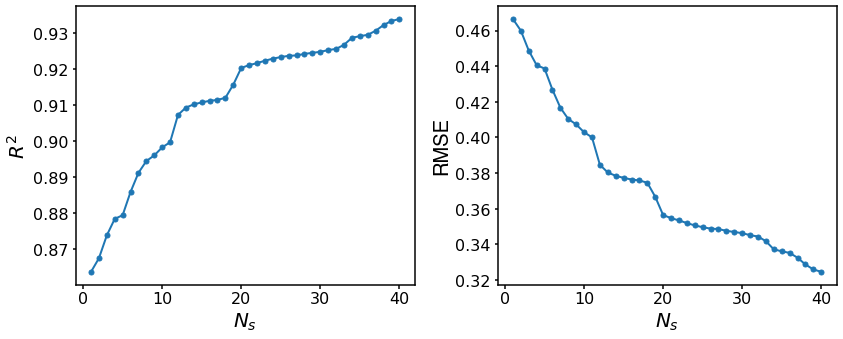

In [8]:
# plot selection results (r2 and rmse as a function of Ns)
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax = axs[0]
ax.plot(np.arange(len(r2)) + 1, r2,'-o', linewidth=2, markersize=5)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
# ax.set_xlim(0, 20)
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'$R^2$', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
ax = axs[1]
ax.plot(np.arange(len(rmse)) + 1, rmse,'-o', linewidth=2, markersize=5)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'RMSE', **hfont)
# ax.set_xlim(0, 20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
fig.tight_layout()
# plt.savefig('SFchoice.png', dpi=300, format='png')
plt.show()

# Result with the chosen number of SFs

In [9]:
Ns = 12 # choose number of SFs
X = np.zeros((Ndata,Ns+Nwindows))
for k in range(Ns):
    X[:,k] = pool[:,selected_idx[k]]
for i in range(Nwindows):
    X[:,i+Ns] = steps[:,i]
reg = LinearRegression(fit_intercept=False).fit(X, E)
Y = reg.predict(X)
# compute offsets to shift the data
X2 = np.copy(X)
for k in range(Ns):
    X2[:,k] = 0.0
offsets = reg.predict(X2)
# print(set(offsets))

# 3-body correction results

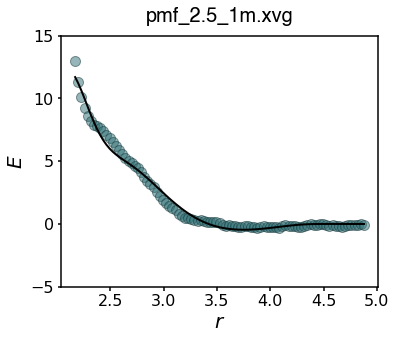

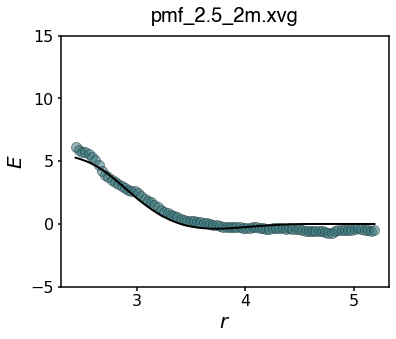

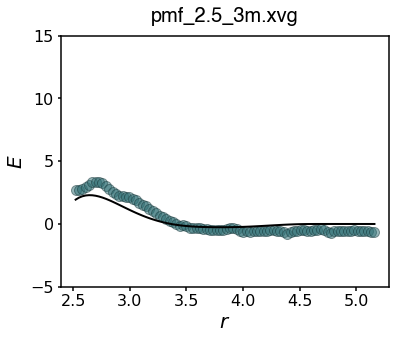

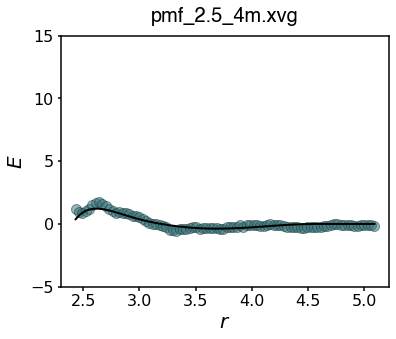

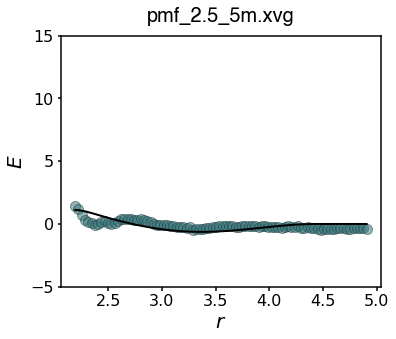

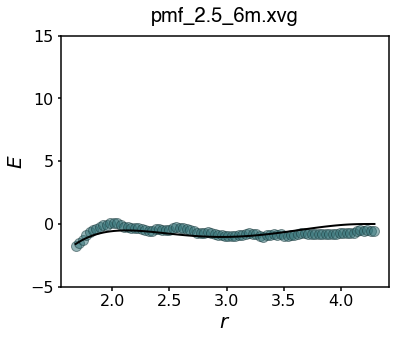

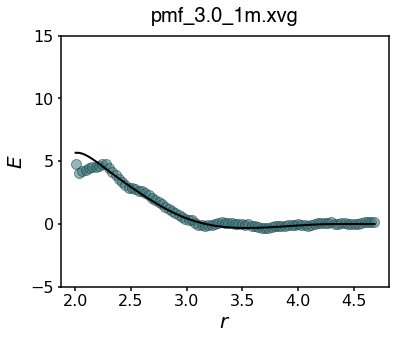

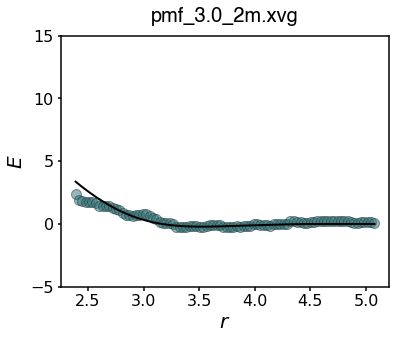

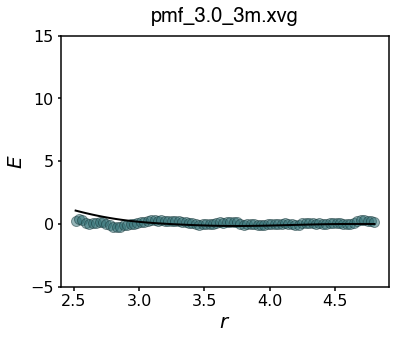

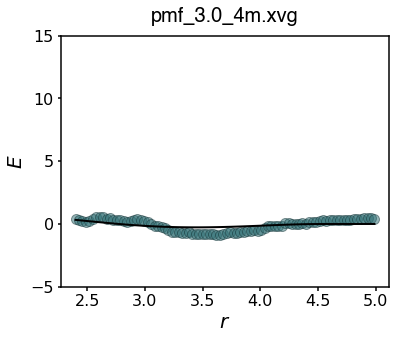

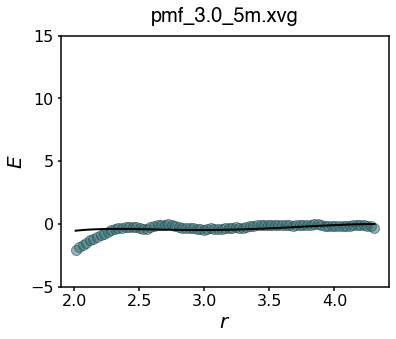

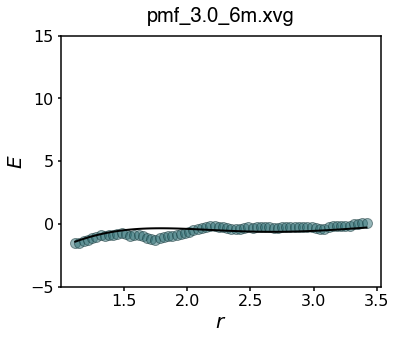

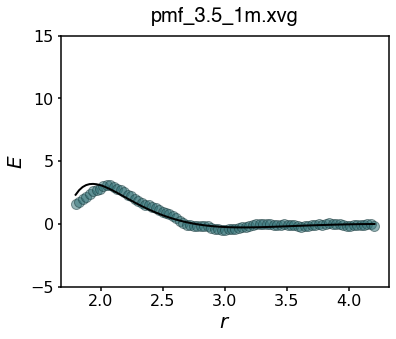

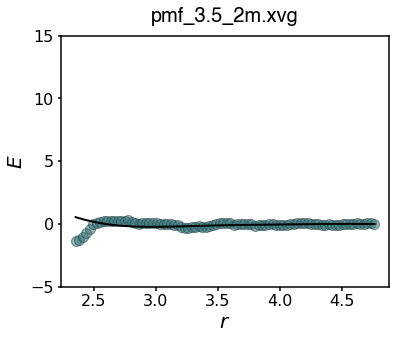

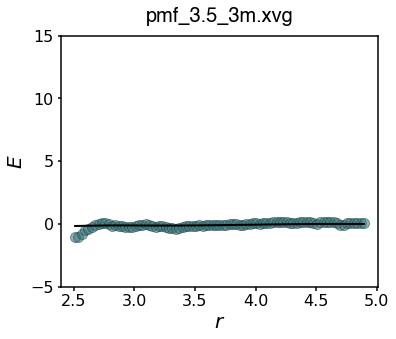

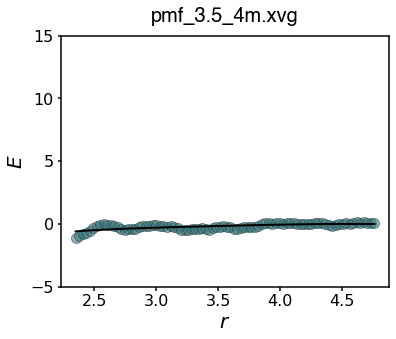

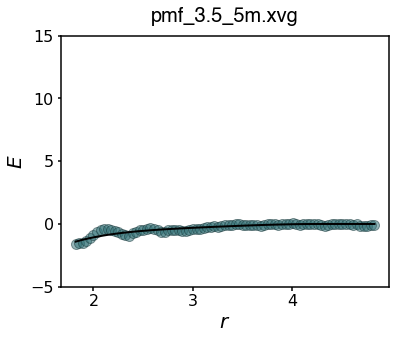

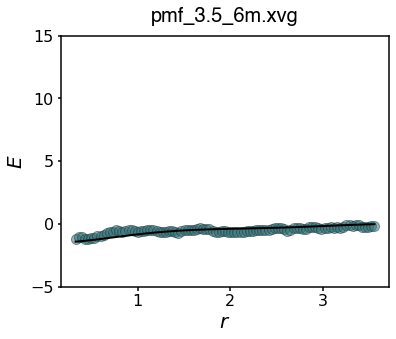

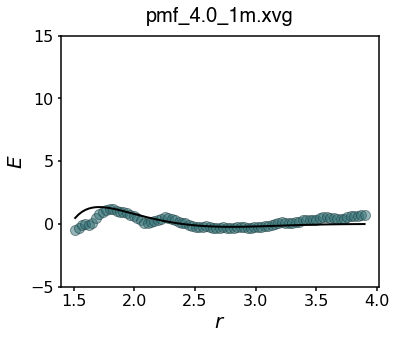

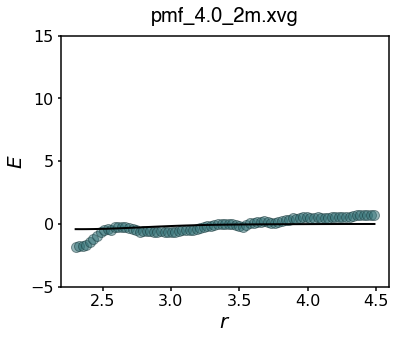

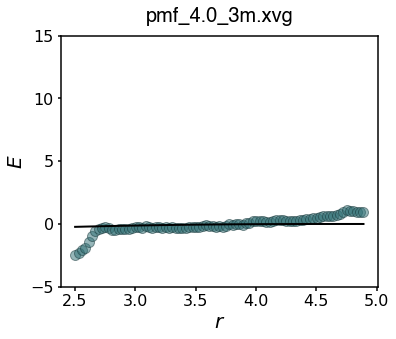

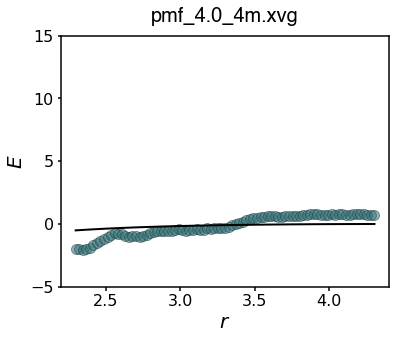

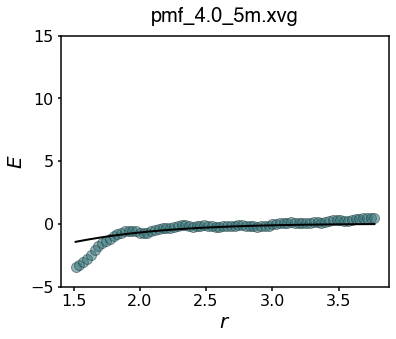

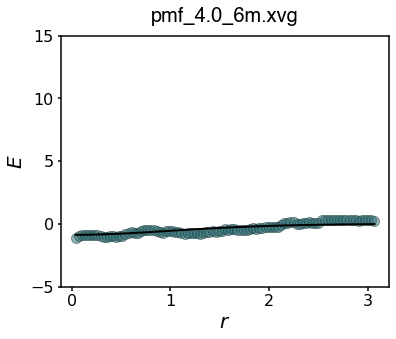

In [10]:
# plot results
color = 0.7*np.array([0.26,0.62,0.65])
cum = 0
for size, file_name in zip(sizes, file_names):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title(file_name, hfont, y=1.03)
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], E[cum:cum+size]-offsets[cum:cum+size], 'o', mec =color*0.5, markersize=10, label='data', mew=1, mfc=color, alpha=0.5)
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Y[cum:cum+size]-offsets[cum:cum+size],'-', linewidth=2, color='k', label='fit')
#     ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], E[cum:cum+size], 'o', mec =color*0.5, markersize=10, label='data', mew=1, mfc=color, alpha=0.5)
#     ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Y[cum:cum+size],'-', linewidth=2, color='k', label='fit')
    ax.set_xlabel(r'$r$', **hfont)
    ax.set_ylabel(r'$E$', **hfont)
    ax.set_ylim(-5,15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    ax.tick_params(which='major', width=1.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
#     ax.legend(prop=dict(size=16))
#     ax.legend(loc="upper right", frameon=False)
    fig.tight_layout()
    plt.show()
    cum += size

# Full 3-body results

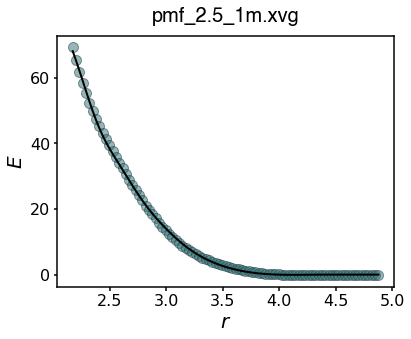

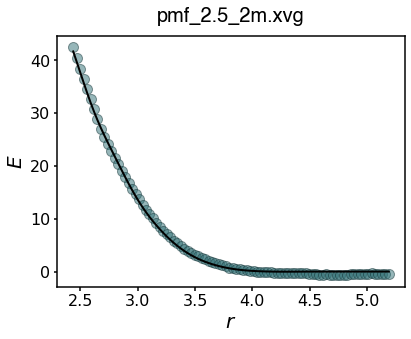

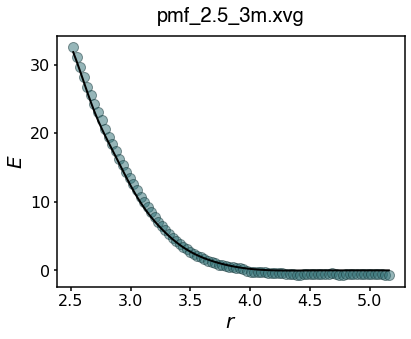

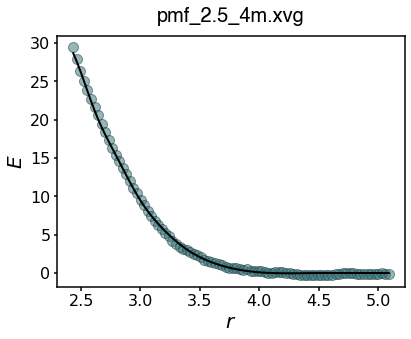

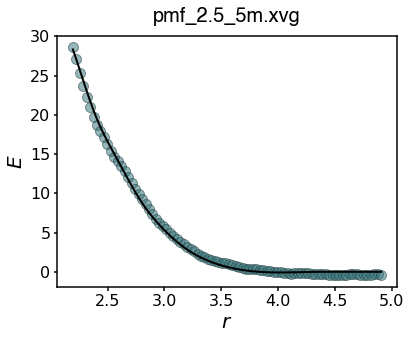

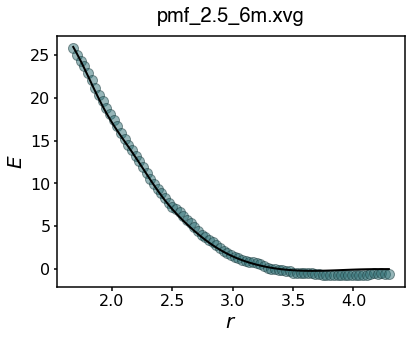

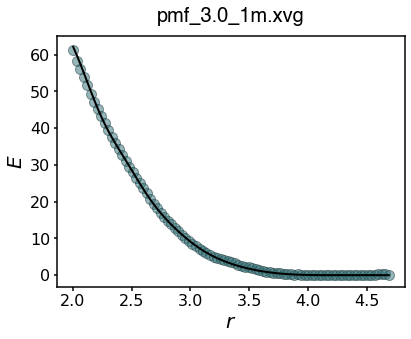

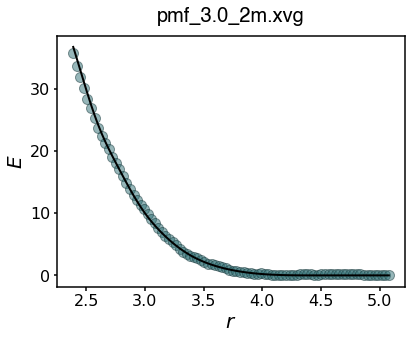

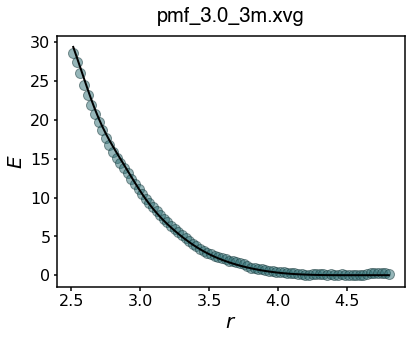

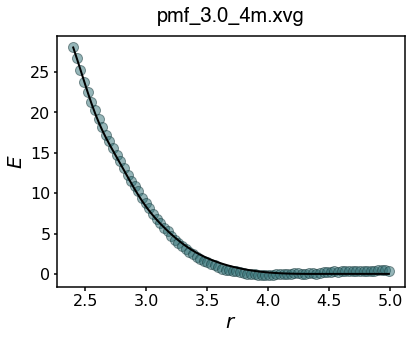

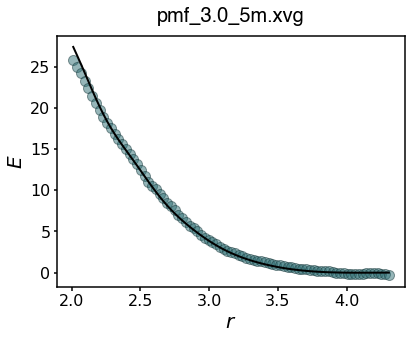

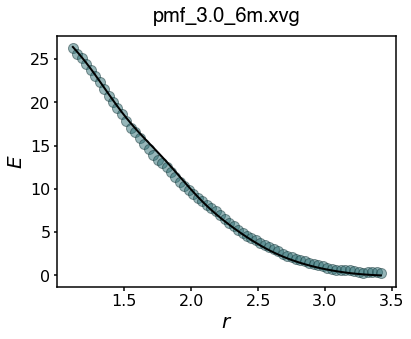

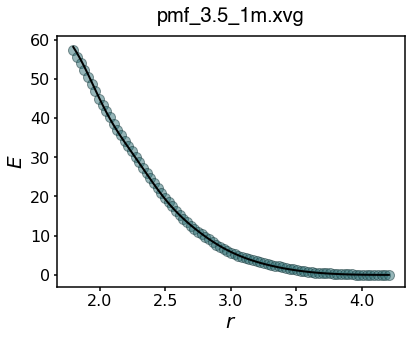

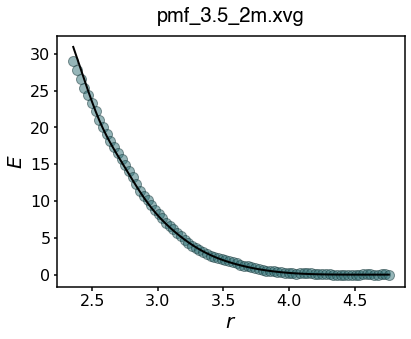

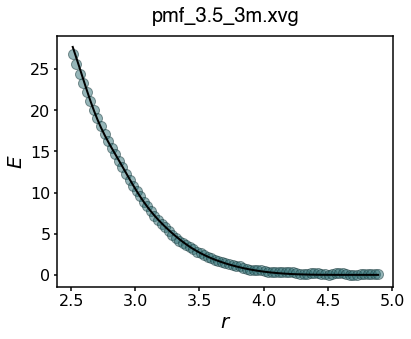

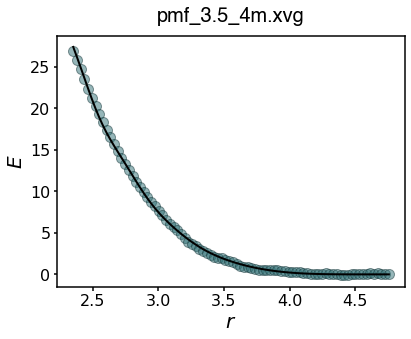

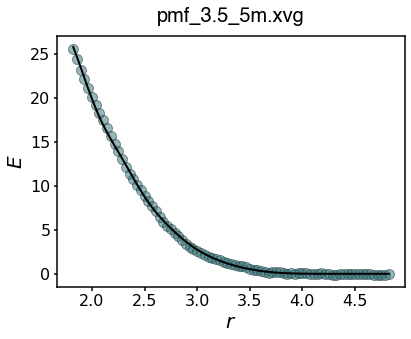

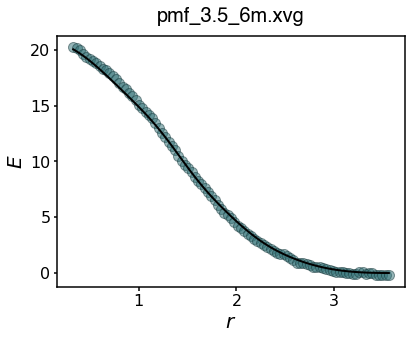

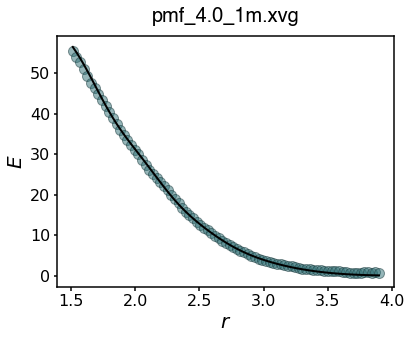

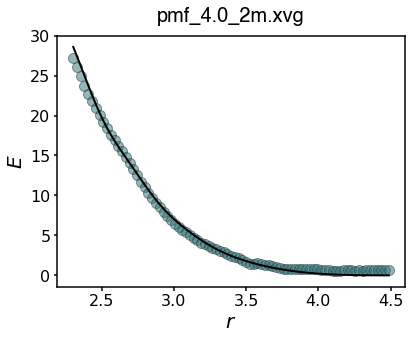

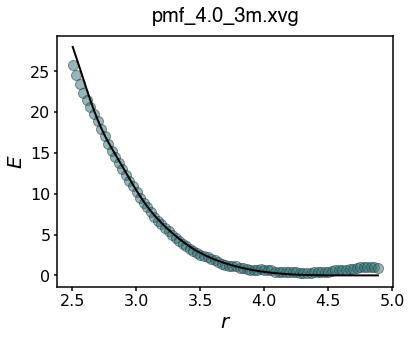

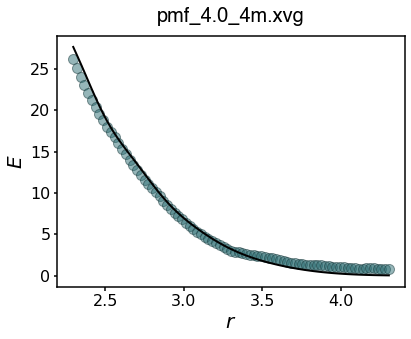

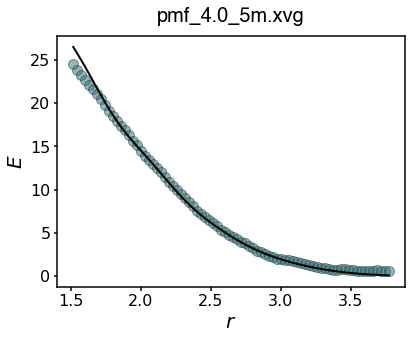

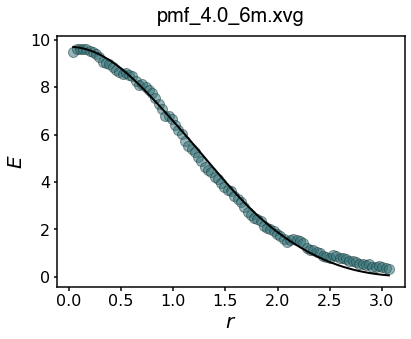

In [43]:
# plot results
Ytot = Y + EXA + EXB
color = 0.7*np.array([0.26,0.62,0.65])
cum = 0
for size, file_name in zip(sizes, file_names):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title(file_name, hfont, y=1.03)
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Etot[cum:cum+size]-offsets[cum:cum+size], 'o', mec =color*0.5, markersize=10, label='data', mew=1, mfc=color, alpha=0.5)
    ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Ytot[cum:cum+size]-offsets[cum:cum+size],'-', linewidth=2, color='k', label='fit')
#     ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Etot[cum:cum+size], 'o', mec =color*0.5, markersize=10, label='data', mew=1, mfc=color, alpha=0.5)
#     ax.plot(parX[cum:cum+size,1]-parA[cum:cum+size,1], Ytot[cum:cum+size],'-', linewidth=2, color='k', label='fit')
    ax.set_xlabel(r'$r$', **hfont)
    ax.set_ylabel(r'$E$', **hfont)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    ax.tick_params(which='major', width=1.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
#     ax.legend(prop=dict(size=16))
#     ax.legend(loc="upper right", frameon=False)
    fig.tight_layout()
    plt.show()
    cum += size

In [46]:
# print parameters of the fit and of the selected SFs
for k in range(Ns):
    print("type = %1d   rc = %.1f   rs = %.1f   eta = %5.3f   l = %3.0f   eps = %1.0f   linear coef = %20.6f" % (type_list[selected_idx[k]], rc_list[selected_idx[k]], rs_list[selected_idx[k]], eta_list[selected_idx[k]], l_list[selected_idx[k]], eps_list[selected_idx[k]], reg.coef_[k]))
    

type = 4   rc = 4.5   rs = 0.0   eta = 0.001   l =   1   eps = 2   linear coef =          5678.761819
type = 4   rc = 4.7   rs = 0.0   eta = 0.001   l =  -1   eps = 8   linear coef =         83731.517691
type = 4   rc = 4.5   rs = 0.0   eta = 0.001   l =  -1   eps = 8   linear coef =         21606.400080
type = 4   rc = 4.7   rs = 0.0   eta = 0.010   l =  -1   eps = 8   linear coef =       -113293.539163
type = 2   rc = 4.7   rs = 2.5   eta = 1.000   l =   0   eps = 0   linear coef =        -37396.859093
type = 4   rc = 4.7   rs = 0.0   eta = 0.010   l =   1   eps = 2   linear coef =         -3588.628512
type = 2   rc = 4.5   rs = 2.5   eta = 8.000   l =   0   eps = 0   linear coef =         19001.507708
type = 3   rc = 4.5   rs = 0.0   eta = 0.100   l =  -1   eps = 8   linear coef =    -154291236.742259
type = 3   rc = 4.7   rs = 0.0   eta = 0.001   l =  -1   eps = 4   linear coef =        472208.573250
type = 3   rc = 4.7   rs = 0.0   eta = 0.100   l =  -1   eps = 4   linear coef =  

In [16]:
# save fitting parameters
if not os.path.exists('./fit3np'):
    os.mkdir('./fit3np')
params = np.array([[reg.coef_[k], type_list[selected_idx[k]], rc_list[selected_idx[k]], rs_list[selected_idx[k]], eta_list[selected_idx[k]], l_list[selected_idx[k]], eps_list[selected_idx[k]]] for k in range(Ns)])
# print(params)
np.save('./fit3np/params.npy', params)